I'll use lambda cloud. Assuming I can create a machine in us-south-2, my storage is already there so I won't need to download data files, scp the tokenizer and model, etc. Here are the instructions from `challenge-25-pretrain-d20/trying-lambda-cloud.ipynb` without the stuff I won't need.

```
ssh ssh ubuntu@[ip]

# ssh key for git
ssh-keygen -t ed25519 -C "lambda-cloud"
cat ~/.ssh/id_ed25519.pub
copy into github UI (https://github.com/settings/keys)

git config --global user.email "ericsilberstein@gmail.com"
git config --global user.name "Eric Silberstein"

# clone this repo
git clone git@github.com:ericsilberstein1/nanogpt-learning.git

# UV
curl -LsSf https://astral.sh/uv/install.sh | sh

# rust
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
echo '. "$HOME/.cargo/env"' >> .bashrc

echo 'export NANOCHAT_BASE_DIR="/home/ubuntu/mynanochat"' >> .bashrc

# in .bashrc add
# export WANDB_API_KEY="XXX"

source .bashrc

cd nanogpt-learning

uv sync
source .venv/bin/activate

# for now until organize this better
uv tool install maturin
cd challenge-07-rust-and-python-simplified-tokenizer/rust_tokenizer
maturin develop
cd -

# looks like lambda automatically runs jupyter but for now at least let me run it
# in the way I understand
uv run jupyter lab --port=7001
jupyter server list

# ON MY LAPTOP make a tunnel to jupyter
ssh -N -L 7001:localhost:7001 ubuntu@[ip]
```

In [2]:
!nvidia-smi

Wed Nov 19 12:55:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:61:00.0 Off |                    0 |
| N/A   24C    P0             69W /  700W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

If my calculation in challenge 26 is right, training will be around 10 minutes, so I'll just run everything from this notebook.

In [1]:
import os
os.environ["PYTHONPATH"] = "../my_nanochat"

First do a CORE evaluation. This is a sanity check. It should match the final eval from the training in challenge 24.

```
Step 21400: CORE metric: 0.2084
```

In [3]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_base_eval -- --source=base --model-tag=d20

W1119 12:55:24.046000 15698 torch/distributed/run.py:803] 
W1119 12:55:24.046000 15698 torch/distributed/run.py:803] *****************************************
W1119 12:55:24.046000 15698 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 12:55:24.046000 15698 torch/distributed/run.py:803] *****************************************
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after 

^ Does not match. That's not good. Will move on and then go back and investigate.

Do the midtraining

In [5]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_mid_train -- --model_tag=d20 --run=challenge-28-1

W1119 13:02:34.300000 240329 torch/distributed/run.py:803] 
W1119 13:02:34.300000 240329 torch/distributed/run.py:803] *****************************************
W1119 13:02:34.300000 240329 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 13:02:34.300000 240329 torch/distributed/run.py:803] *****************************************
overriding model_tag = d20
overriding run = challenge-28-1
user_config: {'run': 'challenge-28-1', 'device_type': '', 'dtype': 'bfloat16', 'num_iterations': -1, 'max_seq_len': 2048, 'device_batch_size': 32, 'unembedding_lr': 0.004, 'embedding_lr': 0.2, 'matrix_lr': 0.02, 'init_lr_frac': 1.0, 'weight_decay': 0.0, 'eval_every': 150, 'eval_tokens': 10485760, 'total_batch_size': 524288, 'dry_run': 0}
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib

In [8]:
!curl -L -o $NANOCHAT_BASE_DIR/identity_conversations.jsonl https://karpathy-public.s3.us-west-2.amazonaws.com/identity_conversations.jsonl


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2235k  100 2235k    0     0  3982k      0 --:--:-- --:--:-- --:--:-- 3977k


In [9]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_mid_train -- --model_tag=d20 --run=challenge-28-2

W1119 13:06:40.457000 241353 torch/distributed/run.py:803] 
W1119 13:06:40.457000 241353 torch/distributed/run.py:803] *****************************************
W1119 13:06:40.457000 241353 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 13:06:40.457000 241353 torch/distributed/run.py:803] *****************************************
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated af

^ The starting bpb validation is way off of the final from the training, this seems bad.

End of base training: step 21400 | Validation bpb: 0.8135

Start of this: step 00000 | Validation bpb: 0.6856

Chat eval

In [11]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_chat_eval -- --source=mid --model-tag=d20

W1119 13:16:40.589000 251134 torch/distributed/run.py:803] 
W1119 13:16:40.589000 251134 torch/distributed/run.py:803] *****************************************
W1119 13:16:40.589000 251134 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 13:16:40.589000 251134 torch/distributed/run.py:803] *****************************************
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated af

Also run limited chat evals on base and mid

In [12]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_chat_eval -- --source=base --model-tag=d20 --max-problems=100

W1119 13:24:59.014000 254422 torch/distributed/run.py:803] 
W1119 13:24:59.014000 254422 torch/distributed/run.py:803] *****************************************
W1119 13:24:59.014000 254422 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 13:24:59.014000 254422 torch/distributed/run.py:803] *****************************************
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated af

In [13]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_chat_eval -- --source=mid --model-tag=d20 --max-problems=100

W1119 13:27:52.132000 256185 torch/distributed/run.py:803] 
W1119 13:27:52.132000 256185 torch/distributed/run.py:803] *****************************************
W1119 13:27:52.132000 256185 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 13:27:52.132000 256185 torch/distributed/run.py:803] *****************************************
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated af

Do the base eval on the mid model

In [14]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_base_eval -- --source=mid --model-tag=d20

W1119 13:29:45.629000 257849 torch/distributed/run.py:803] 
W1119 13:29:45.629000 257849 torch/distributed/run.py:803] *****************************************
W1119 13:29:45.629000 257849 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 13:29:45.629000 257849 torch/distributed/run.py:803] *****************************************
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated af

Repeat the base eval on the base model

In [15]:
!torchrun --standalone --nproc_per_node=8 -m scripts.my_base_eval -- --source=base --model-tag=d20

W1119 13:33:21.170000 481715 torch/distributed/run.py:803] 
W1119 13:33:21.170000 481715 torch/distributed/run.py:803] *****************************************
W1119 13:33:21.170000 481715 torch/distributed/run.py:803] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1119 13:33:21.170000 481715 torch/distributed/run.py:803] *****************************************
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated af

### Back on laptop

Did those runs above, terminated the 8xH100 machine, now back on my mac. (Spent 0.82 hours on the machine and spent $19.53.)

Copied the model files to `files_copied_from_servers/challenge-28-midtrain-d20`

Things to figure out after the run:

1) Why was final val bpb in base training (done in challenge 25) 0.8135 but the starting one in this mid training run was 0.6856?
   
2) Why was the final CORE metric in base training 0.2084 but the one I measured here on the same model was 0.2012?

3) Can SpellingBee accuracy really be 96.88%?

Will investigate these in `investigate-questions.ipynb`

Other observations:

- The training took around 9 minutes
  
- The training seemed to behave judging by the training loss and bpb validation (graphs pasted below)

- I ran the base eval on the base model twice and both times it gave CORE = 0.2012 (expected them to match, sanity check)

- I ran the base eval on the mid model and it gave CORE = 0.0198, a decrease (is this expected?)

- I ran a short version of the chat eval on base and mid and saw:
    - ARC-Easy accuracy: 25.00% -> 39.00%
    - ARC-Challenge accuracy: 30.00% -> 33.00%
    - MMLU accuracy: 28.00% -> 31.00%
    - GSM8K accuracy: 0.00% -> 1.00%
    - HumanEval accuracy: 0.00% -> 7.00%
    - SpellingBee accuracy: 0.00% -> 97.00%

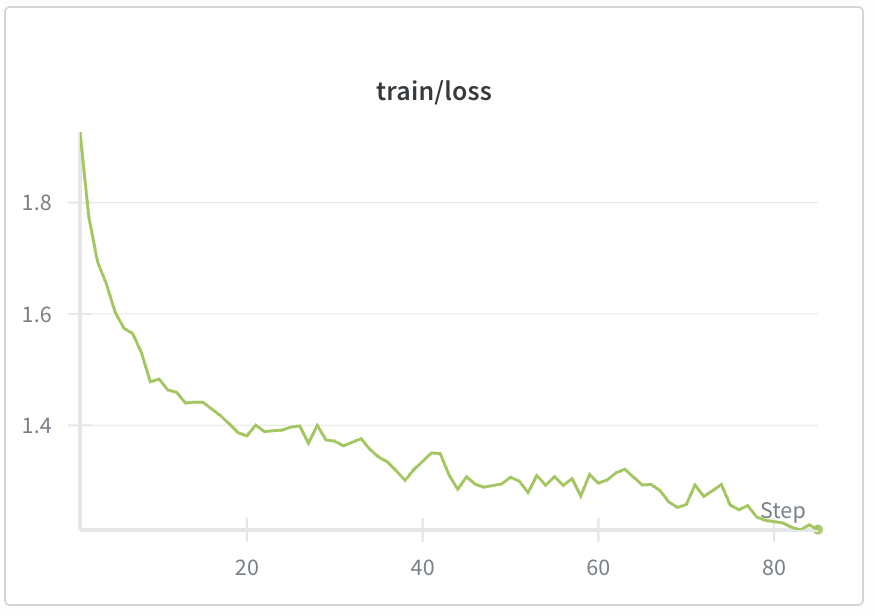

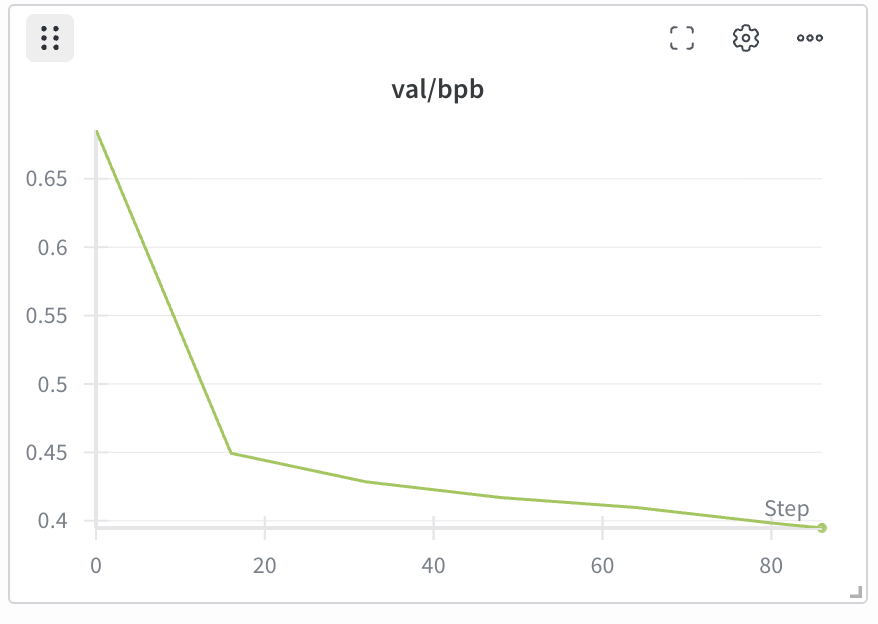